# Tutorial on *tensorpack* framework

### What is *tensorpack* framework:

A neural net training interface based on TensorFlow.

- [Source code](https://github.com/ppwwyyxx/tensorpack)
- [Performance oriented *Tensorflow* wrapper](http://tensorpack.readthedocs.io/en/latest/tutorial/index.html#a-high-level-glance)

#### Features: 

- Focus on training speed
- Focus on large datasets


### Content
- Parallel data flow: augmentation, batching, prefetch
- Trainers on multi-GPU
- Logging


## Example k-folds training convnet on CIFAR10

In [1]:
import os
import sys
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
# Specify where located tensorpack datasets:
# os.environ['TENSORPACK_DATASET'] = "/media/user/fast_storage/tensorpack_data/"
# Specify temporary folder for ZMQ pipe files
os.environ['TENSORPACK_PIPEDIR'] = "tmp_pipedir"
# !mkdir $TENSORPACK_PIPEDIR

In [5]:
import numpy as np
from tensorpack.utils.utils import fix_rng_seed
from tensorpack.dataflow.dataset.cifar import Cifar10

In [6]:
seed = 12345
fix_rng_seed(seed)

### Define CIFAR10 dataset 

A dataset class is derived from `tensorpack.dataflow.Dataflow` and defines two methods:
- `get_data`
- `size`

In the following example we will resize images to 48x48 instead of their original size 32x32. This is due to minimal input size of VGG19 used as example model.

In [7]:
train_ds = Cifar10('train')

[0917 00:11:29 @cifar.py:33] Found cifar10 data in /Users/vfomin/tensorpack_data/cifar10_data.


(32, 32, 3) uint8 13 224   5
(32, 32, 3) uint8 2 235   4
(32, 32, 3) uint8 0 255   1
(32, 32, 3) uint8 19 254   0
(32, 32, 3) uint8 13 251   8
(32, 32, 3) uint8 5 248   4
(32, 32, 3) uint8 17 251   2
(32, 32, 3) uint8 0 243   1
(32, 32, 3) uint8 0 255   9
(32, 32, 3) uint8 0 223   7
(32, 32, 3) uint8 9 216   4
(32, 32, 3) uint8 18 192   2
(32, 32, 3) uint8 5 255   8
(32, 32, 3) uint8 3 255   0
(32, 32, 3) uint8 6 189   6


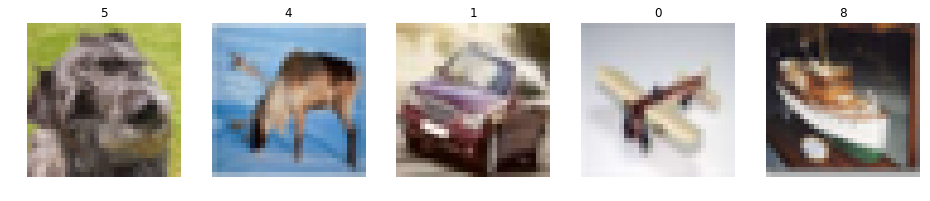

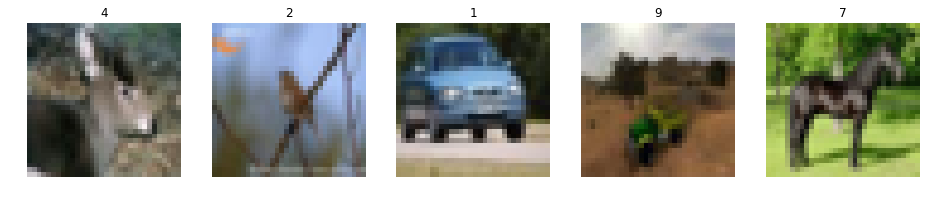

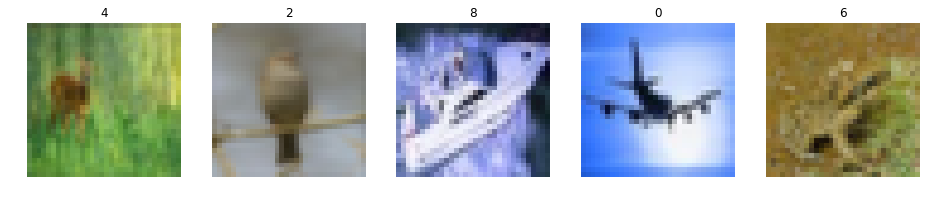

In [8]:
train_ds.reset_state()

max_loops = 15
counter = 0
n = 5 
for x, y in train_ds.get_data():    
    print(x.shape, x.dtype, x.min(), x.max(), ' ', y)
    
    if counter % n == 0:
        plt.figure(figsize=(16, 6))
    plt.subplot(1, n, counter % n + 1)                         
    plt.imshow(x)
    plt.title("{}".format(y))
    plt.axis('off')

    counter += 1
    if counter == max_loops:
        break

### Data augmentation & batching

In [9]:
from tensorpack.dataflow import AugmentImageComponent, BatchData, PrefetchData, PrefetchDataZMQ
from tensorpack.dataflow.imgaug import Resize, Flip, RandomOrderAug, RandomApplyAug, RandomChooseAug, Affine
from tensorpack.dataflow.imgaug import Hue, Saturation, Brightness, Contrast, Gamma
from tensorpack.dataflow.imgaug import MinMaxNormalize, ToFloat32
from tensorpack.dataflow import SelectComponent, FixedSizeData
from tensorpack.dataflow.imgaug import AugmentorList
from tensorpack.dataflow.imgaug import Resize

In [10]:
import cv2

# Train augmenters:
geom_augmenters = [
    Resize(shape=(48, 48), interp=cv2.INTER_CUBIC),
    RandomOrderAug([
        Flip(horiz=True, prob=0.5),
        Flip(vert=True, prob=0.5),        
        RandomApplyAug(
                Affine(scale=(0.95, 1.05), 
                       translate_frac=(0.05, 0.05), 
                       rotate_max_deg=45.0,
                       shear=15.0,
                       border=cv2.BORDER_REPLICATE, border_value=0.0),
                prob=0.75
        ),
    ])
]

color_augmenters = [
    RandomChooseAug([
        Hue(range=(0.0, 180.0), rgb=True),
        Saturation(alpha=0.5, rgb=True),
        Brightness(delta=50),
        Contrast(factor_range=(0.75, 1.25)),
        Gamma()
    ]),
    ToFloat32(),
    MinMaxNormalize(0.0, 1.0)    
]

#### Fast benchmarking:
- no prefetching
- prefetching with multiprocessing
- prefetching with ZeroMQ

In [11]:
batch_size = 16

In [15]:
aug_train_ds = AugmentImageComponent(train_ds, geom_augmenters, index=0, copy=False)
aug_train_ds = AugmentImageComponent(aug_train_ds, color_augmenters, index=0, copy=False)  
train_batchs = BatchData(aug_train_ds, batch_size=batch_size, use_list=True, remainder=False)

In [16]:
%%timeit -r3 -n5
train_batchs.reset_state()
loop_max_counter = 500
for batch_imgs, batch_labels in train_batchs.get_data():    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break        

5 loops, best of 3: 3.73 s per loop


#### Prefetching with multiprocessing

In [12]:
pref_train_ds = PrefetchData(train_ds, nr_prefetch=5*batch_size, nr_proc=1)
aug_train_ds = AugmentImageComponent(pref_train_ds, geom_augmenters, index=0, copy=False)
aug_train_ds = AugmentImageComponent(aug_train_ds, color_augmenters, index=0, copy=False)  
train_batches = BatchData(aug_train_ds, batch_size=batch_size, use_list=True, remainder=False)
train_batches = PrefetchData(train_batches, nr_prefetch=batch_size, nr_proc=15)

In [13]:
train_batches.reset_state()
loop_max_counter = 20
for batch_imgs, batch_labels in train_batches.get_data():    
    print(len(batch_imgs), batch_imgs[0].shape, batch_labels)
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break        

16 (48, 48, 3) [5, 0, 2, 8, 2, 3, 0, 8, 0, 6, 6, 6, 8, 5, 4, 0]
16 (48, 48, 3) [1, 7, 6, 8, 0, 5, 1, 5, 8, 1, 2, 5, 2, 5, 2, 8]
16 (48, 48, 3) [1, 4, 0, 4, 2, 3, 0, 3, 5, 2, 4, 0, 5, 0, 1, 2]
16 (48, 48, 3) [1, 8, 0, 1, 0, 7, 5, 6, 4, 0, 1, 5, 2, 7, 6, 5]
16 (48, 48, 3) [1, 3, 9, 5, 2, 2, 0, 5, 4, 5, 8, 3, 5, 0, 3, 6]
16 (48, 48, 3) [4, 8, 8, 3, 0, 5, 2, 2, 7, 1, 2, 5, 2, 8, 8, 2]
16 (48, 48, 3) [2, 9, 4, 5, 7, 8, 0, 6, 9, 7, 4, 8, 6, 4, 5, 3]
16 (48, 48, 3) [0, 0, 3, 6, 8, 0, 7, 4, 1, 3, 3, 2, 4, 2, 5, 8]
16 (48, 48, 3) [3, 7, 1, 8, 1, 0, 7, 2, 9, 4, 8, 5, 8, 5, 3, 2]
16 (48, 48, 3) [7, 4, 5, 8, 3, 6, 1, 6, 3, 5, 8, 6, 0, 8, 2, 1]
16 (48, 48, 3) [4, 8, 5, 7, 0, 4, 8, 7, 4, 0, 3, 5, 1, 2, 6, 8]
16 (48, 48, 3) [7, 8, 8, 8, 8, 7, 8, 0, 7, 1, 5, 4, 2, 2, 3, 4]
16 (48, 48, 3) [6, 3, 6, 9, 0, 8, 7, 2, 9, 5, 2, 9, 5, 3, 4, 9]
16 (48, 48, 3) [4, 7, 9, 1, 7, 5, 9, 5, 7, 7, 0, 2, 6, 3, 9, 7]
16 (48, 48, 3) [3, 5, 8, 5, 0, 8, 9, 3, 5, 2, 2, 2, 5, 5, 9, 7]
16 (48, 48, 3) [8, 7, 3, 0, 8, 3, 7, 6, 

In [14]:
%%timeit -r3 -n5
train_batches.reset_state()
loop_max_counter = 500
for batch_imgs, batch_labels in train_batches.get_data():    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break        

5 loops, best of 3: 1.28 s per loop


#### Prefetching with ZeroMQ

In [17]:
if sys.platform == 'darwin':
    raise Exception("ZMQ does not work correctly on MacOSX")
    
pref_train_ds = PrefetchData(train_ds, nr_prefetch=5*batch_size, nr_proc=1)
aug_train_ds = AugmentImageComponent(pref_train_ds, geom_augmenters, index=0, copy=False)
aug_train_ds = AugmentImageComponent(aug_train_ds, color_augmenters, index=0, copy=False)  
train_batches = BatchData(aug_train_ds, batch_size=batch_size, use_list=True, remainder=False)
train_batches = PrefetchDataZMQ(train_batches, nr_proc=15)

Exception: ZMQ does not work correctly on MacOSX

In [20]:
if sys.platform == 'darwin':
    raise Exception("ZMQ does not work correctly on MacOSX")

train_batches.reset_state()
loop_max_counter = 20
for batch_imgs, batch_labels in train_batches.get_data():    
    print(len(batch_imgs), batch_imgs[0].shape, batch_labels)
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break        

Exception: ZMQ does not work correctly on MacOSX

In [23]:
if sys.platform == 'darwin':
    raise Exception("ZMQ does not work correctly on MacOSX")


%%timeit -r3 -n5
train_batchs.reset_state()
loop_max_counter = 500
for batch_imgs, batch_labels in train_batches.get_data():    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break        

SyntaxError: invalid syntax (<ipython-input-23-ff9948f8a37f>, line 5)

In [18]:
pref_train_ds = PrefetchData(train_ds, nr_prefetch=5*batch_size, nr_proc=1)
aug_train_ds = AugmentImageComponent(pref_train_ds, geom_augmenters, index=0, copy=False)
aug_train_ds = AugmentImageComponent(aug_train_ds, color_augmenters, index=0, copy=False)  
train_batches = BatchData(aug_train_ds, batch_size=batch_size, use_list=True, remainder=False)
if sys.platform != 'darwin':
    train_batches = PrefetchDataZMQ(train_batches, nr_proc=15)

16 (48, 48, 3) [5, 4, 1, 0, 8, 4, 2, 1, 9, 7, 4, 2, 8, 0, 6, 0]
float32
0.0 1.0
16 (48, 48, 3) [8, 4, 5, 0, 8, 3, 0, 2, 4, 7, 2, 3, 0, 5, 3, 8]
float32
0.0 1.0
16 (48, 48, 3) [3, 6, 5, 1, 1, 7, 0, 0, 0, 2, 8, 5, 3, 6, 9, 8]
float32
0.0 1.0
16 (48, 48, 3) [1, 8, 2, 0, 8, 5, 9, 1, 0, 7, 0, 7, 3, 7, 1, 2]
float32
0.0 1.0
16 (48, 48, 3) [7, 7, 6, 1, 4, 1, 9, 2, 3, 4, 4, 4, 5, 6, 2, 1]
float32
0.0 1.0
16 (48, 48, 3) [0, 5, 5, 4, 0, 8, 9, 5, 6, 7, 2, 5, 7, 2, 5, 3]
float32
0.0 1.0
16 (48, 48, 3) [8, 8, 5, 8, 7, 1, 6, 5, 5, 2, 3, 2, 5, 8, 5, 0]
float32
0.0 1.0
16 (48, 48, 3) [2, 6, 0, 8, 8, 6, 3, 6, 1, 7, 5, 7, 4, 1, 4, 8]
float32
0.0 1.0
16 (48, 48, 3) [4, 1, 0, 0, 8, 4, 2, 6, 0, 3, 0, 8, 7, 7, 4, 2]
float32
0.0 1.0
16 (48, 48, 3) [4, 5, 1, 3, 2, 8, 6, 8, 8, 5, 5, 0, 0, 5, 8, 9]
float32
0.0 1.0


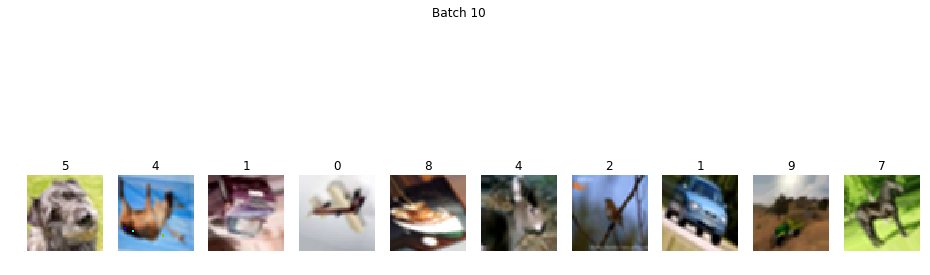

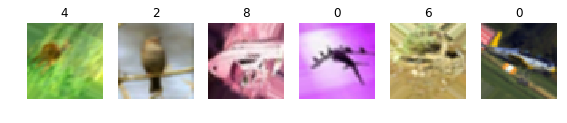

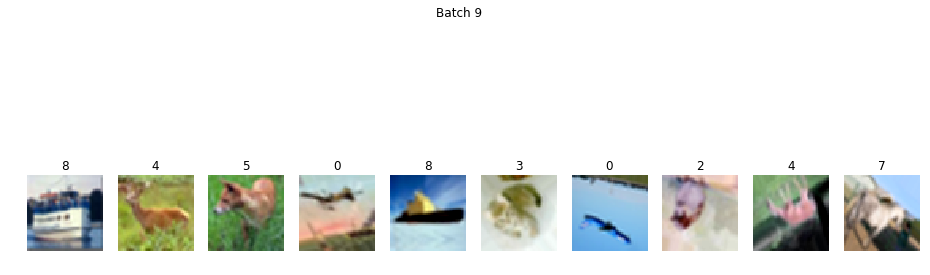

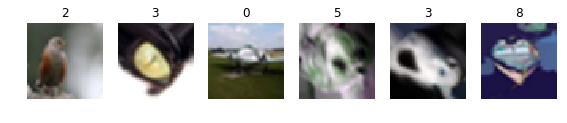

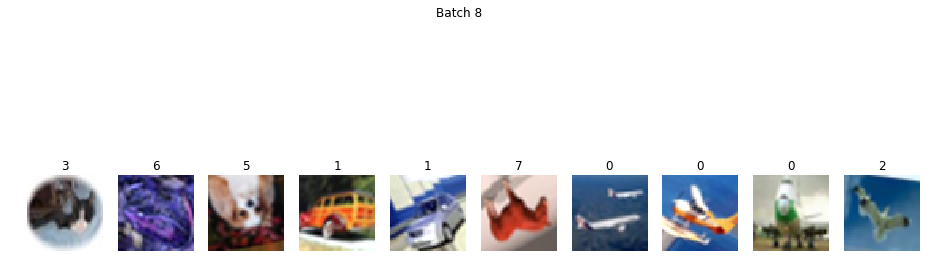

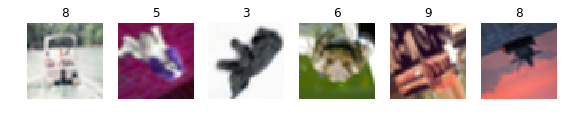

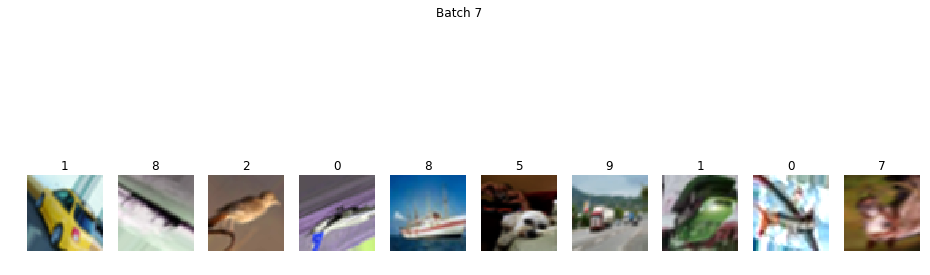

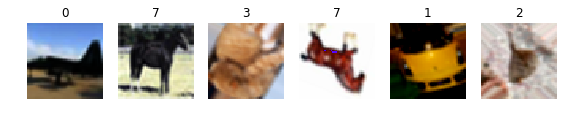

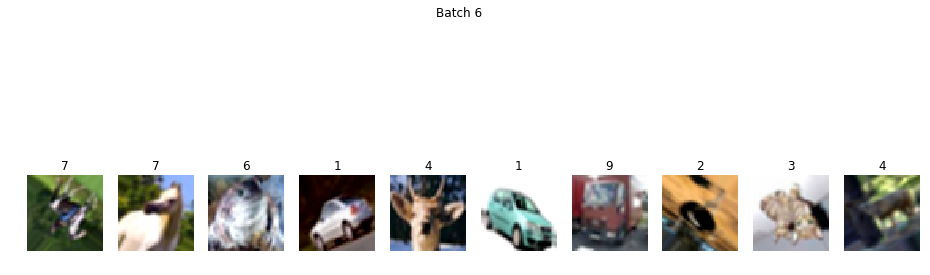

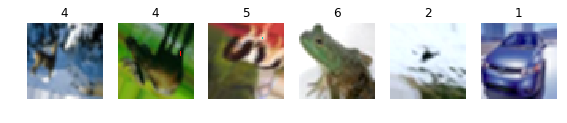

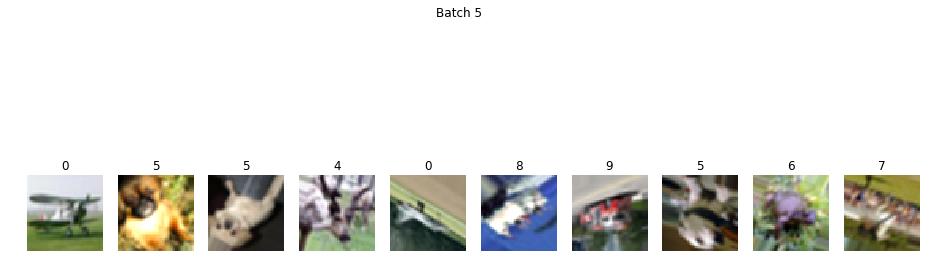

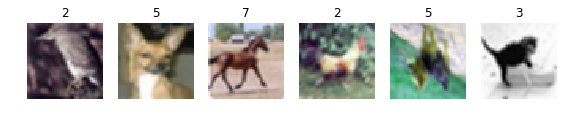

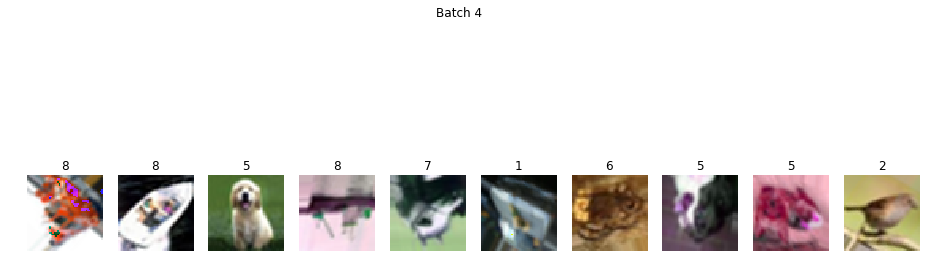

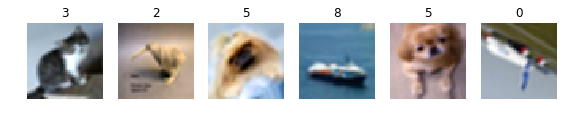

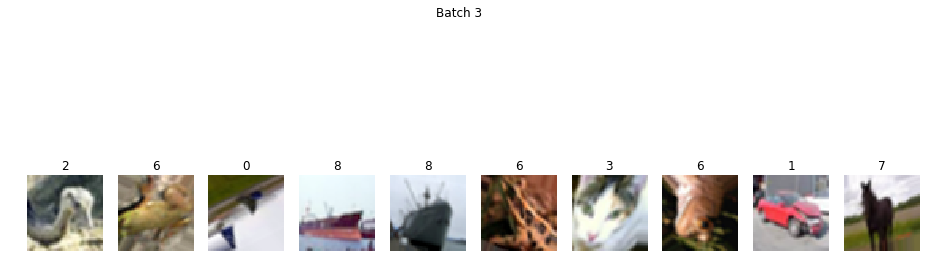

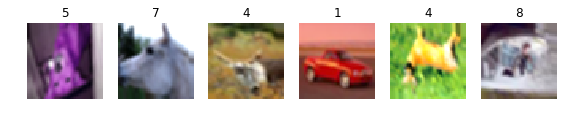

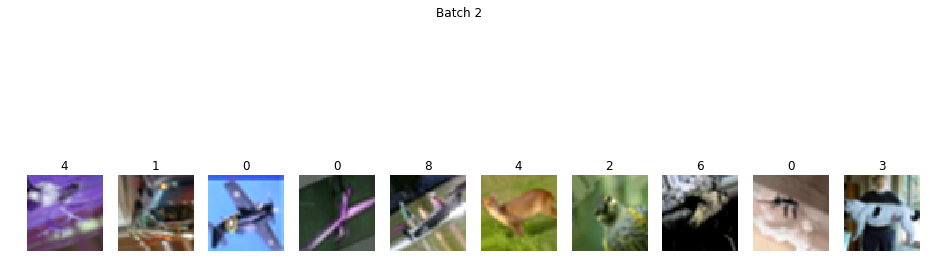

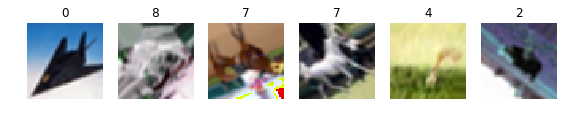

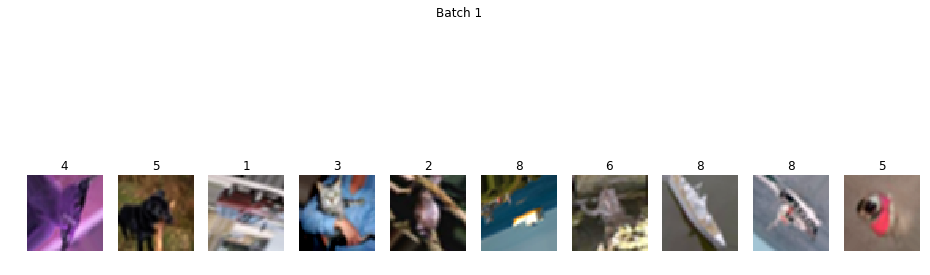

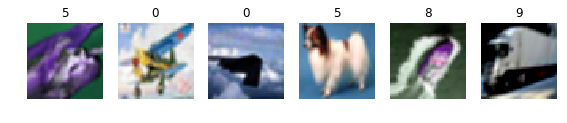

In [19]:
loop_max_counter = 10
train_batches.reset_state()

for batch_imgs, batch_labels in train_batches.get_data():
    print(len(batch_imgs), batch_imgs[0].shape, batch_labels)
    print(batch_imgs[0].dtype)
    print(batch_imgs[0].min(), batch_imgs[0].max())
            
    n = 10
    s = min(batch_size, len(batch_imgs))
    plt.figure(figsize=(16, 6))
    plt.suptitle("Batch %i" % loop_max_counter)
    for counter in range(s):
        if counter > 0 and counter % n == 0:
            plt.figure(figsize=(16, 16))
        plt.subplot(1, n, counter % n + 1)        
        img = batch_imgs[counter]
        label = batch_labels[counter]
                        
        plt.imshow(img)
        plt.title("{}".format(label))
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break        

## Model definition

Tensorpack framework allows to build a graph using 
- tensorflow
- Keras
- other tensorflow based frameworks

### How to build a graph
`ModelDesc` is an abstraction over the most common type of models people train. It assumes:

1. Training is a single-cost optimized by a single tf.train.Optimizer.

2. The graph can be trivially duplicated for data-parallel training or inference.

Example of a custom model:
```
class MyModel(ModelDesc):
    def _get_inputs(self):
        return [InputDesc(...), InputDesc(...)]

    def _build_graph(self, inputs):
        tensorA, tensorB = inputs
        # build the graph
        self.cost = xxx  # define the cost tensor

    def _get_optimizer(self):
      return tf.train.GradientDescentOptimizer(0.1)
```

### 1. Using a model written in Keras

Let's load VGG19 architecture from `keras.applications`

**Important**: Make sure that Keras backend is TF



In [24]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Input
from keras.models import Model

Using TensorFlow backend.


In [31]:
import tensorflow as tf

print("Tensorflow version: %s" % tf.__version__)

from tensorpack.graph_builder import ModelDesc, InputDesc
from tensorpack.utils.argtools import memoized
from tensorpack.tfutils.summary import add_moving_summary, add_param_summary
from tensorpack.tfutils import get_global_step_var
from tensorpack.tfutils.symbolic_functions import accuracy, get_scalar_var

Tensorflow version: 1.1.0


In [32]:
class VGG19Model(ModelDesc):    

    def __init__(self):
        self.name = "vgg19_32x32"
    
    def _get_inputs(self):
        return [InputDesc(tf.float32, (None, 48, 48, 3), 'input'),
                InputDesc(tf.int32, (None,), 'label')]
    
    @memoized   # this is necessary for Keras to work under tensorpack
    def _build_keras_model(self, input_tensor):        
        vgg19 = VGG19(include_top=False, weights=None, input_tensor=input_tensor)        
        x = vgg19.outputs[0]
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        logits = Dense(10, name='logits')(x)        
        model = Model(inputs=vgg19.inputs, outputs=logits)        
        return model
                
    def _build_graph(self, inputs):
        image, label = inputs

        keras_input_tensor = Input(tensor=image)
        vgg19 = self._build_keras_model(keras_input_tensor)        
        logits = vgg19.outputs[0]

        # Define loss function as cost tensor:
        cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        self.cost = tf.reduce_mean(cost, name='crossentropy_loss')

        # Define training metrics
        acc = accuracy(logits, label)
        # monitor training accuracy (computed as EMA (exponential moving average))
        add_moving_summary(tf.reduce_mean(acc, name='train_accuracy'))
        
        # Define some other monitoring variables:
        add_param_summary(('.*/W', ['histogram']))   # monitor W

    def _get_optimizer(self):
        # We can define learning_rate scheduling here or in training callbacks
        lr = get_scalar_var('learning_rate', 1e-2, summary=True)
        return tf.train.AdamOptimizer(lr, epsilon=1e-3)

Let us inspect and visualize the graph with defined model. During training we will use Tensorboard for these purposes

In [33]:
from graphviz import Digraph

def tf_to_dot(graph, display_all_nodes=False):
    dot = Digraph()
    node_ops_to_skip = ['Const', 'RandomUniform', 'Assign', 'AssignAdd',
                        'Identity', 'VariableV2', 'Shape', 'StridedSlice', 'Pack']
    node_names_to_skip = ['random', 'flatten/Prod']
    for n in graph.as_graph_def().node:
        if not display_all_nodes:
            if n.op in node_ops_to_skip:
                continue
            skip = False
            for name_to_skip in node_names_to_skip:
                if name_to_skip in n.name:
                    skip = True
                    break
            if skip:
                continue
        dot.node(n.name, label=n.name)
        for i in n.input:
            dot.edge(i, n.name)            
    return dot

In [34]:
# Build graph
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    model = VGG19Model()
    inputs = model._get_inputs()
    inputs = [i.build_placeholder() for i in inputs]
    model._build_graph(inputs)

Following [TF docs](https://www.tensorflow.org/versions/r1.3/programmers_guide/graphs), 
graph contains its structure, composed of nodes and edges and collections. Let us inspect its content.

In [35]:
print(len(g.as_graph_def().node))
print("First node: \n", g.as_graph_def().node[0])

411
First node: 
 name: "input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
    }
  }
}



What about graph collections. TF collections is a dictionary that stores various objects, referenced by keys (standard `tf.GraphKeys` and user-defined). Let us inspect defined collection keys:

In [36]:
g.get_all_collection_keys()

['variables', 'MOVING_SUMMARY_OPS', 'summaries', 'trainable_variables']

We can observe standard keys `tf.GraphKeys.TRAINABLE_VARIABLES`, `tf.GraphKeys.SUMMARIES`, `tf.GraphKeys.GLOBAL_VARIABLES` and tensorpack defined key `MOVING_SUMMARY_OPS`. Graph collection objects associated with `trainable_variables` are mostly convolution, fully-connected kernels and biases (trainable variables). We can observe 5 blocks of VGG19 and final fully-connected layers:

In [49]:
g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv3/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv3

Graph collection objects associated with `variables` are trainable and some other variables used for training. If we skip trainable variables we observe metrics defined in our `VGG19Model`:

In [38]:
list(set(g.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)) - set(g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)))

[<tf.Variable 'EMA/train_accuracy:0' shape=() dtype=float32_ref>,
 <tf.Variable 'EMA/train_accuracy/biased:0' shape=() dtype=float32_ref>,
 <tf.Variable 'EMA/train_accuracy/local_step:0' shape=() dtype=float32_ref>]

In [39]:
g.get_collection(tf.GraphKeys.SUMMARIES)

[<tf.Tensor 'train_accuracy-summary:0' shape=() dtype=string>]

In [40]:
from tensorpack.utils.naming import MOVING_SUMMARY_OPS_KEY

g.get_collection(MOVING_SUMMARY_OPS_KEY)

[<tf.Tensor 'EMA/train_accuracy_EMA_apply:0' shape=() dtype=float32_ref>]

Let us visualize important nodes and edges

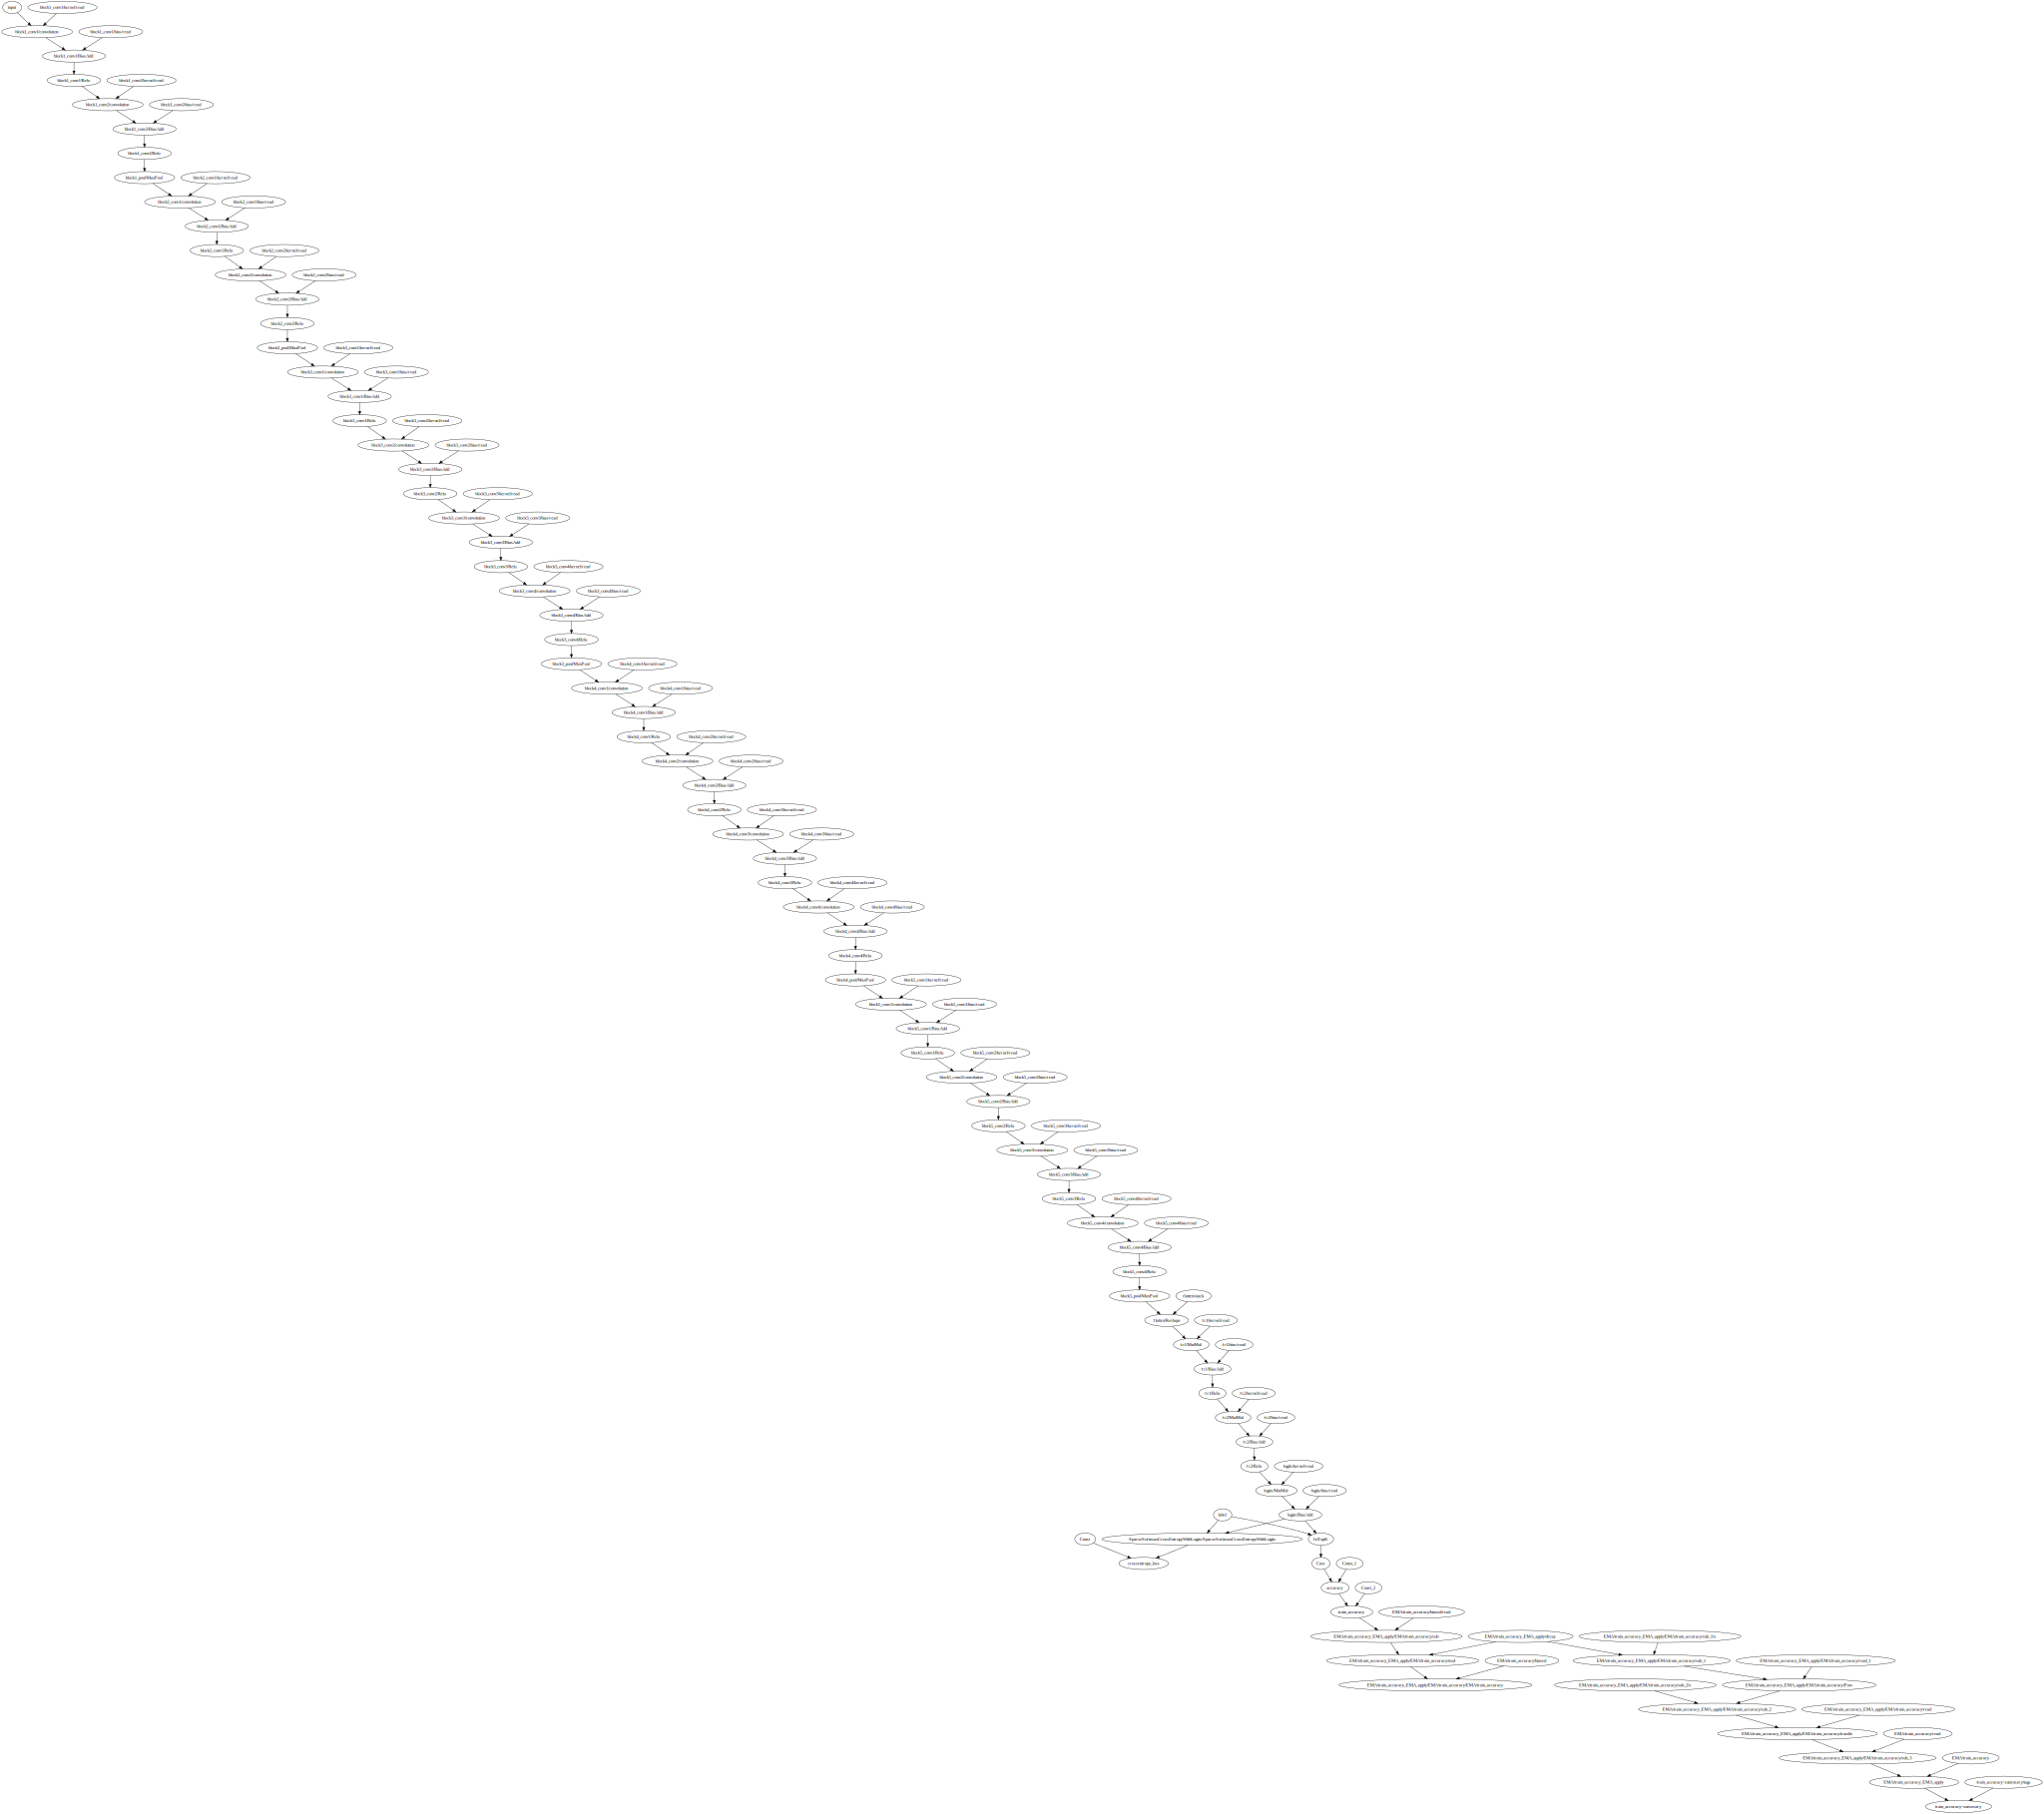

In [41]:
tf_to_dot(g)

## Training on k-folds


- Define training configuration: model, train/val datasets, callbacks, ...
- Define trainer


### Training configuration

We need to define an instance of [`TrainConfig`](http://tensorpack.readthedocs.io/en/latest/tutorial/trainer.html) which takes as arguments:

- training dataflow (instance of `DataFlow`)

- model (instance of `ModelDesc`)

- callbacks, extra callbacks, monitors: [doc](http://tensorpack.readthedocs.io/en/latest/tutorial/callback.html), [api](http://tensorpack.readthedocs.io/en/latest/modules/callbacks.html):
    - model saver and best model saver
    - validation (InferenceRunner)
    - hyper parameters setter (automatic or manual): learning_rate scheduling 
    - progress bar
    - logging into a file, folder for Tensorboard, ...
    - ...
    - option to pause the training and start a debug shell, to observe what's going on
    - record GPU utilizations during training
    - send validation metrics to the smartphone :)
    
- starting epoch, max epoch

- number of towers (multi-GPU training & predictions)


In [42]:
from tensorpack.train import TrainConfig

from tensorpack.callbacks import Callback, ModelSaver, MaxSaver, ScheduledHyperParamSetter, GPUUtilizationTracker
from tensorpack.callbacks import InferenceRunner, ScalarStats, CallbackToHook

In [43]:
# If we use Keras written model, we need to define a specific callback:
import keras.backend as KB

class KerasCallback(Callback):
    def __init__(self, is_train):
        self._is_train = is_train
        self._learning_phase = KB.learning_phase()

    def _before_run(self, ctx):
        return tf.train.SessionRunArgs(
            fetches=[], feed_dict={self._learning_phase: int(self._is_train)})


In [44]:
def get_config(model, train_ds, val_ds):
        
    callbacks = [
        # Keras callback:
        KerasCallback(True),
        # Save model every epoch
        ModelSaver(), 
        # Separately save the model with maximum value of some statistics.
        MaxSaver('val-accuracy', filename='%s_max_val_acc.tfmodel' % (model.name)), 
        # Schedule the learning rate based on epoch number
        ScheduledHyperParamSetter('learning_rate',
                                  [(0, 1e-2), (25, 5e-3), (50, 1e-3), (75, 1e-4), (90, 1e-5)], 
                                  interp=None # or 'linear'
                                 ),
        # Record GPU utilizations during training : it will start a process to run `nvidia-smi` every second
        # within the epoch and write average utilization to monitors.
        GPUUtilizationTracker(),
        
        # Validation callback: runs a list of `Inferencer` on validation dataset.
        InferenceRunner(val_ds, 
                        [
                            ScalarStats('crossentropy_loss'),
                        ], 
                        extra_hooks=[
                            CallbackToHook(KerasCallback(False)),
                        ]
                       ),
    ]
    # By default, following callbacks are provided as `extra_callbacks` in addition to defined `callbacks`:
    # - MovingAverageSummary : maintains the moving average of summarized tensors in every step
    # - ProgressBar : progress bar based on tqdm
    # - MergeAllSummaries : evaluates all summaries by `tf.summary.merge_all`, and write to logs.
    # - RunUpdateOps : runs operations from the collection UPDATE_OPS every step    
    #      Some useful links on UPDATE_OPS: 
    #      - http://ruishu.io/2016/12/27/batchnorm/
    #      - https://github.com/tensorflow/tensorflow/issues/4361

    # Default monitors are 
    # - TFEventWriter : write summaries to TensorFlow event file. Visualization with Tensorboard
    # - JSONWriter : write all scalar data to a json file, grouped by their global step.
    # - ScalarPrinter : print scalar data into terminal.
    
    return TrainConfig(
        model=model,
        dataflow=train_ds, 
        starting_epoch=1,
        max_epoch=100,
        callbacks=callbacks,
        monitors=None,
    )

Let's divide training dataset into 5 folds, define training/validation data transformations and batching methods:

In [45]:
from tensorpack.dataflow import ProxyDataFlow
from sklearn.model_selection import KFold


class KFoldsDataset(ProxyDataFlow):
    """
    Extract k-fold train/val datasets
    """

    def __init__(self, ds, data_type, fold_index, n_folds):
        """
        Args:
            ds (DataFlow): input DataFlow
            data_type: train or val
            fold_index: fold index
            n_folds: number of folds for K-Folds train/val dataset extraction
        """
        assert fold_index >= 0 or fold_index < n_folds
        assert data_type in ['train', 'val']
        super(KFoldsDataset, self).__init__(ds)        
        
        kfs = KFold(n_splits=n_folds)
        index = 0
        for train_indices, val_indices in kfs.split(range(ds.size())):
            if index != fold_index:
                index += 1
                continue
            self.indices = train_indices if data_type == 'train' else val_indices
            break

    def size(self):
        return len(self.indices)
            
    def get_data(self):
        index = 0
        for dp in self.ds.get_data():            
            if index in self.indices:
                yield dp
            index += 1

In [46]:
# Train augmenters:
train_geom_augmenters = [
    Resize(shape=(48, 48), interp=cv2.INTER_CUBIC),
    RandomOrderAug([
        Flip(horiz=True, prob=0.5),
        Flip(vert=True, prob=0.5),        
        RandomApplyAug(
                Affine(scale=(0.95, 1.05), 
                       translate_frac=(0.05, 0.05), 
                       rotate_max_deg=45.0,
                       shear=15.0,
                       border=cv2.BORDER_REPLICATE, border_value=0.0),
                prob=0.75
        ),
    ])
]

train_color_augmenters = [
    RandomChooseAug([
        Hue(range=(0.0, 180.0), rgb=True),
        Saturation(alpha=0.5, rgb=True),
        Brightness(delta=50),
        Contrast(factor_range=(0.75, 1.25)),
        Gamma()
    ]),
    ToFloat32(),
    MinMaxNormalize(0.0, 1.0)    
]

# Validation augmenters:
val_geom_augmenters = [
    Resize(shape=(48, 48), interp=cv2.INTER_CUBIC),
    RandomOrderAug([
        Flip(horiz=True, prob=0.5),
        Flip(vert=True, prob=0.5),        
    ])
]

val_color_augmenters = [
    ToFloat32(),
    MinMaxNormalize(0.0, 1.0)    
]

In [47]:
train_ds = Cifar10('train')
pref_train_ds = PrefetchData(train_ds, nr_prefetch=5*batch_size, nr_proc=1)
aug_train_ds = AugmentImageComponent(pref_train_ds, geom_augmenters, index=0, copy=False)
aug_train_ds = AugmentImageComponent(aug_train_ds, color_augmenters, index=0, copy=False)  
train_batches = BatchData(aug_train_ds, batch_size=batch_size, use_list=True, remainder=False)
if sys.platform != 'darwin':
    train_batches = PrefetchDataZMQ(train_batches, nr_proc=15)

[0917 00:34:48 @cifar.py:33] Found cifar10 data in /Users/vfomin/tensorpack_data/cifar10_data.


In [ ]:
with tf.Graph().as_default():
    logger.set_logger_dir(os.path.join('train_log', 'cifar10_fold_%i' % val_fold_index))
    config = get_config(val_fold_index=val_fold_index, n_folds=n_folds, cifar_classnum=10)
    trainer = QueueInputTrainer(config)

In [ ]:
from sklearn.model_selection import KFold


class KFoldsDataset(ProxyDataFlow):
    """
    Extract k-fold train/val datasets
    """

    def __init__(self, ds, data_type, fold_index, n_folds):
        """
        Args:
            ds (DataFlow): input DataFlow
            data_type: train or val
            fold_index: fold index
            n_folds: number of folds for K-Folds train/val dataset extraction
        """
        assert fold_index >= 0 or fold_index < n_folds
        assert data_type in ['train', 'val']
        super(KFoldsDataset, self).__init__(ds)        
        
        kfs = KFold(n_splits=n_folds)
        index = 0
        for train_indices, val_indices in kfs.split(range(ds.size())):
            if index != fold_index:
                index += 1
                continue
            self.indices = train_indices if data_type == 'train' else val_indices
            break

    def size(self):
        return len(self.indices)
            
    def get_data(self):
        index = 0
        for dp in self.ds.get_data():            
            if index in self.indices:
                yield dp
            index += 1

In [4]:
def get_data(train_or_test, val_fold_index=0, n_folds=5, cifar_classnum=10):
    isTrain = train_or_test == 'train'
    if cifar_classnum == 10:
        ds = dataset.Cifar10(train_or_test)
    else:
        ds = dataset.Cifar100(train_or_test)
        
    if isTrain:
        ds = KFoldsDataset(ds, 'train', fold_index=val_fold_index, n_folds=n_folds)
    else:        
        ds = KFoldsDataset(ds, 'val', fold_index=val_fold_index, n_folds=n_folds)
    
    if isTrain:
        augmentors = [
            imgaug.RandomCrop((30, 30)),
            imgaug.Flip(horiz=True),
            imgaug.Brightness(63),
            imgaug.Contrast((0.2, 1.8)),
            imgaug.GaussianDeform(
                [(0.2, 0.2), (0.2, 0.8), (0.8, 0.8), (0.8, 0.2)],
                (30, 30), 0.2, 3),
            imgaug.MeanVarianceNormalize(all_channel=True)
        ]
    else:
        augmentors = [
            imgaug.CenterCrop((30, 30)),
            imgaug.MeanVarianceNormalize(all_channel=True)
        ]
    ds = AugmentImageComponent(ds, augmentors)
    ds = BatchData(ds, 128, remainder=not isTrain)
    if isTrain:
        ds = PrefetchDataZMQ(ds, 5)
    return ds

In [5]:
def get_config(val_fold_index=0, n_folds=5, cifar_classnum=10):
    # prepare dataset
    dataset_train = get_data(train_or_test='train', 
                             val_fold_index=val_fold_index, 
                             n_folds=n_folds, 
                             cifar_classnum=cifar_classnum)
    dataset_val = get_data(train_or_test='test', 
                           val_fold_index=val_fold_index, 
                           n_folds=n_folds, 
                           cifar_classnum=cifar_classnum)

    def lr_func(lr):
        if lr < 5e-3:
            raise StopTraining()
        return lr * 0.31
    return TrainConfig(
        model=Model(cifar_classnum),
        dataflow=dataset_train,
        callbacks=[
            ModelSaver(),
            InferenceRunner(dataset_val, ClassificationError()),
            StatMonitorParamSetter('learning_rate', 'val_error', lr_func,
                                   threshold=0.001, last_k=10),
        ],
        max_epoch=150,
    )

In [6]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [7]:
n_folds = 5

for val_fold_index in range(n_folds):
    with tf.Graph().as_default():
        logger.set_logger_dir(os.path.join('train_log', 'cifar10_fold_%i' % val_fold_index))
        config = get_config(val_fold_index=val_fold_index, n_folds=n_folds, cifar_classnum=10)
        trainer = QueueInputTrainer(config)
        trainer.train()

[0827 20:06:10 @logger.py:93] WRN Log directory train_log/cifar10_fold_0 exists! Please either backup/delete it, or use a new directory.
[0827 20:06:10 @logger.py:95] WRN If you're resuming from a previous run you can choose to keep it.
[0827 20:06:10 @logger.py:96] Select Action: k (keep) / b (backup) / d (delete) / n (new) / q (quit):
d
[0827 20:06:12 @logger.py:74] Argv: /usr/local/lib/python3.5/site-packages/ipykernel/__main__.py -f /Users/vfomin/Library/Jupyter/runtime/kernel-f993b982-d27d-43e2-9f17-5b3e577150e6.json
[0827 20:06:12 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /Users/vfomin/tensorpack_data for datasets.
[0827 20:06:12 @cifar.py:33] Found cifar10 data in /Users/vfomin/tensorpack_data/cifar10_data.
[0827 20:06:13 @deform.py:77] WRN GaussianDeform is slow. Consider using it with 4 or more prefetching processes.
[0827 20:06:13 @cifar.py:33] Found cifar10 data in /Users/vfomin/tensorpack_data/cifar10_data.
[0827 20:06:13 @inference_runner.py:81] InferenceRu

  0%|          |0/312[00:00<?,?it/s]

[0827 20:07:19 @base.py:246] Detected Ctrl-C and exiting main loop.


 60%|#####9    |187/312[00:59<00:39, 3.15it/s]

[0827 20:07:19 @input_source.py:204] EnqueueThread QueueInput/input_queue Exited.
[0827 20:07:19 @logger.py:74] Argv: /usr/local/lib/python3.5/site-packages/ipykernel/__main__.py -f /Users/vfomin/Library/Jupyter/runtime/kernel-f993b982-d27d-43e2-9f17-5b3e577150e6.json
[0827 20:07:19 @cifar.py:33] Found cifar10 data in /Users/vfomin/tensorpack_data/cifar10_data.


[0827 20:07:20 @deform.py:77] WRN GaussianDeform is slow. Consider using it with 4 or more prefetching processes.


AttributeError: 'KFoldsDataset' object has no attribute 'indices'